In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt
# from ipywidgets import interactive
%matplotlib inline

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
import random

## Load data

In [3]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = pd.read_excel(root_path + 'data/adp_dataset_master.xlsx', index_col=None)
meta = meta[meta.date == 210616].reset_index()
meta = meta[['mouse','date','area']]

meta.mouse = meta.mouse.astype(int)
meta.date = meta.date.astype(int)
meta

,mouse,date,area
0,1338,210616,V1


In [5]:
nset = len(meta.index); ncell = []; nori = 7; nisi = 1; nframe_trial = 77
dir_name = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\','/')

vis_ad = np.empty([0,nori]); 
dfof_ad = np.empty([0,nori]); dfof_tg = np.empty([0,nori])
dfof_ad_std = np.empty([0,nori]); dfof_tg_std = np.empty([0,nori])
trace = np.empty([0,nori,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'vis_driven' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['sig_vis_ad']), axis=0)
    
    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            trace_flat[icell][iori][:] = trace_align['trace_avg'][icell][iori].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([121], (121, 7), (121, 7), (121, 7), (121, 7, 77))

In [6]:
meta['ncell'] = ncell
meta

,mouse,date,area,ncell
0,1338,210616,V1,121


In [7]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell.tail()

,mouse,area
116,1338,V1
117,1338,V1
118,1338,V1
119,1338,V1
120,1338,V1


## Adaptation magnitude

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [8]:
adp_mag = dfof_tg / dfof_ad - 1
adp_mag = adp_mag * vis_ad
adp_mag[adp_mag == 0] = np.nan
adp_mag.shape

(121, 7)

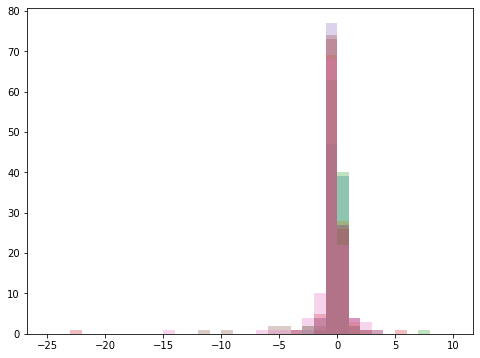

In [9]:
plt.figure(figsize=(8,6))
for iori in np.arange(nori):
#     plt.hist(adp_mag[:,iori], alpha=0.3)
    plt.hist(adp_mag[:,iori], bins=np.linspace(-25,10,36), alpha=0.3)

(-2.0, 2.0)

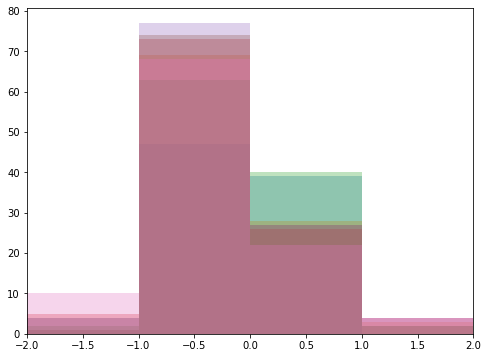

In [10]:
plt.figure(figsize=(8,6))
for iori in np.arange(nori):
#     plt.hist(adp_mag[:,iori], alpha=0.3)
    plt.hist(adp_mag[:,iori], bins=np.linspace(-25,10,36), alpha=0.3)
plt.xlim(-2,2)

In [11]:
mag = adp_mag.flatten('F')
ad = dfof_ad.flatten('F')
tg = dfof_tg.flatten('F')
stim = [np.arange(nori)] * adp_mag.shape[0]
stim_flat = np.sort([item for sublist in stim for item in sublist])
stim_flat.shape, mag.shape, ad.shape

((847,), (847,), (847,))

In [12]:
df = pd.DataFrame({'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
df

,stim,ad,tg,mag,abs_mag
0,0,0.004911,0.010702,NaN,NaN
1,0,0.096553,0.070448,-0.270371,0.270371
2,0,0.043873,0.061639,0.404955,0.404955
3,0,0.023006,0.024814,0.078625,0.078625
4,0,0.048574,0.052035,0.071251,0.071251
...,...,...,...,...,...
842,6,0.017647,0.012288,-0.303705,0.303705
843,6,0.010285,0.000552,-0.946363,0.946363
844,6,-0.000823,0.002919,-4.545728,4.545728
845,6,0.008689,0.013116,0.509572,0.509572


In [13]:
mag_mean = df[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
df[['mag','stim']].groupby(['stim'], sort=False).describe()

mag                                                                 \
      count      mean        std         min       25%       50%       75%   
stim                                                                         
0      87.0 -0.055722   0.333009   -1.237675 -0.296637 -0.069403  0.132607   
1     103.0 -0.097542   0.573734   -3.090850 -0.298679 -0.115285  0.056971   
2     112.0  0.105213   1.533797   -2.221198 -0.364330 -0.068741  0.176492   
3     113.0  1.572952  19.538023  -22.783439 -0.437561 -0.184868  0.166089   
4     116.0 -0.166487   0.747440   -3.618084 -0.423483 -0.192269  0.054999   
5     116.0 -0.541183   1.723481  -11.646174 -0.478584 -0.203371 -0.010074   
6     117.0 -1.753809  12.978342 -139.651267 -0.652298 -0.318741 -0.012836   

                  
             max  
stim              
0       0.883748  
1       2.833710  
2      12.859465  
3     205.983176  
4       3.543835  
5       1.681211  
6       2.819863

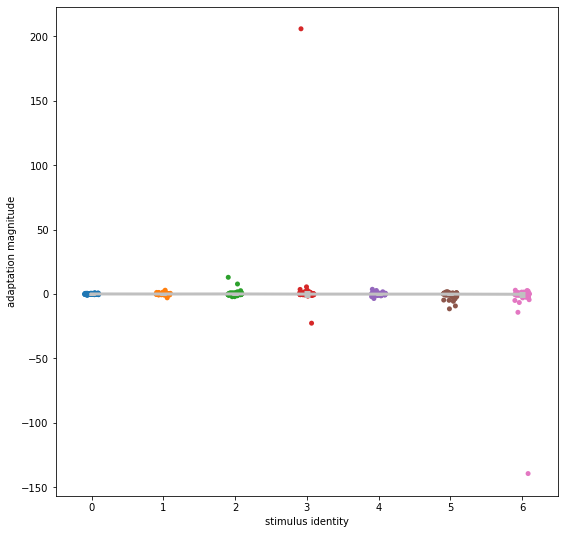

In [14]:
plt.figure(figsize=(9,9))

plt.errorbar(np.arange(nori), mag_median, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df);

# plt.ylim(-5,5);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

### add dfof_ad thresholding

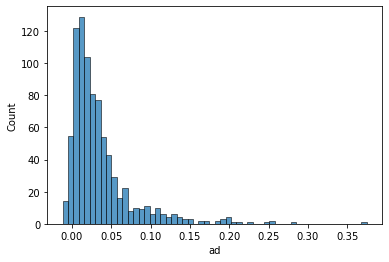

In [15]:
sns.histplot(data=df, x='ad');

In [16]:
sum(df.ad < 0) / len(df) # percent of negative dfof_ad

0.0590318772136954

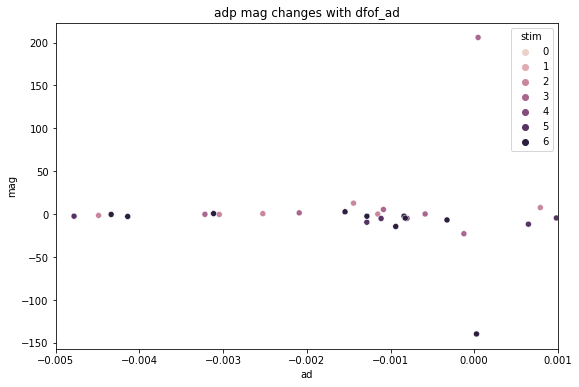

In [17]:
plt.figure(figsize=(9,6))
ax = sns.scatterplot(data=df, x="ad", y="mag", hue="stim")
plt.xlim([-0.005,0.001]);
ax.set(title = 'adp mag changes with dfof_ad');

In [22]:
# df2 = df.sort_values(by=['ad'])

# def f(win):
#     plt.figure(figsize=(15,5))
#     plt.plot(df2['ad'], df2['mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
#     plt.xlim([-0.002,0.002])
#     plt.xlabel('dfof_ad')
#     plt.ylabel('adaptation mag rolling mean')
#     plt.title('adp mag rolling mean change with dfof_ad of cells')
#     plt.show()

# interactive_plot = interactive(f, win=(2, 20))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

In [23]:
# df2 = df.sort_values(by=['ad'])

# def f(win):
#     plt.figure(figsize=(15,5))
#     plt.plot(df2['ad'], df2['mag'].rolling(win, min_periods=1).std(), alpha=0.7)
#     plt.xlim([-0.002,0.002])
#     plt.xlabel('dfof_ad')
#     plt.ylabel('adaptation mag rolling std')
#     plt.title('adp mag rolling std change with dfof_ad of cells')
#     plt.show()

# interactive_plot = interactive(f, win=(2, 20))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

cell selection: vis_ad only, with dfof_ad thresholding

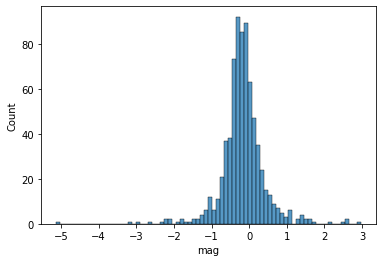

In [29]:
dfof_threshold = 0.002
df_th = df.copy()
df_th.loc[df_th[np.abs(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan
sns.histplot(data=df_th, x='mag');

In [30]:
df_th[['mag','ad','tg','stim']].groupby(['stim'], sort=False).describe()

mag                                                              \
      count      mean       std       min       25%       50%       75%   
stim                                                                      
0      87.0 -0.055722  0.333009 -1.237675 -0.296637 -0.069403  0.132607   
1     101.0 -0.096928  0.400290 -1.088400 -0.292219 -0.115285  0.056290   
2     108.0 -0.090391  0.584746 -2.221198 -0.367597 -0.084761  0.161613   
3     108.0 -0.134984  0.627825 -1.774232 -0.438076 -0.196271  0.081717   
4     113.0 -0.184539  0.561863 -2.140044 -0.423297 -0.192613  0.030113   
5     109.0 -0.164131  0.552767 -2.346489 -0.415025 -0.190284  0.012717   
6     109.0 -0.361829  0.910761 -5.131041 -0.592932 -0.308804 -0.012836   

                   ad            ...                         tg            \
           max  count      mean  ...       75%       max  count      mean   
stim                             ...                                        
0     0.883748  121.0  0.042030  ...  0.045001  0.251187  121.0  0.040626   
1     1.367621  121.0  0.034104  ...  0.046836  0.185454  121.0  0.029591   
2     2.468145  121.0  0.047613  ...  0.053728  0.374842  121.0  0.046022   
3     2.959567  121.0  0.027841  ...  0.032663  0.189126  121.0  0.022785   
4     2.612212  121.0  0.041966  ...  0.052322  0.257215  121.0  0.032933   
5     1.681211  121.0  0.027210  ...  0.032339  0.173376  121.0  0.022095   
6     2.606359  121.0  0.024358  ...  0.030030  0.191323  121.0  0.018860   

                                                                  
           std       min       25%       50%       75%       max  
stim                                                              
0     0.052997 -0.012422  0.011102  0.025786  0.047083  0.334161  
1     0.032131 -0.005394  0.007854  0.019366  0.038624  0.164210  
2     0.063872 -0.023221  0.011427  0.028055  0.049301  0.367123  
3     0.026434 -0.006986  0.006236  0.014414  0.032302  0.181473  
4     0.036089 -0.006134  0.010711  0.024228  0.043397  0.217830  
5     0.026837 -0.008429  0.006920  0.013198  0.029065  0.145712  
6     0.028491 -0.009693  0.002936  0.011041  0.022364  0.149292  

[7 rows x 24 columns]

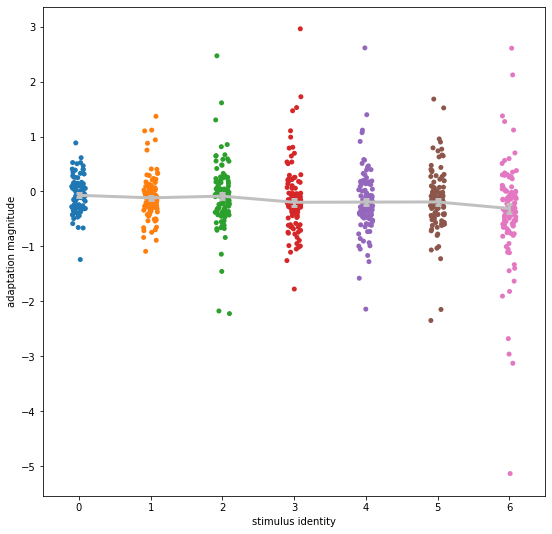

In [55]:
mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
mag_95ci = df_th[['mag','stim']].groupby(['stim'], sort=False).quantile(0.95).to_numpy().flatten() - mag_median # 95% confidence interval
mag_05ci = mag_median - df_th[['mag','stim']].groupby(['stim'], sort=False).quantile(0.05).to_numpy().flatten()

plt.figure(figsize=(9,9))
plt.errorbar(np.arange(nori), mag_median, yerr=mag_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="mag", data=df_th);
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

In [49]:
# anova test for adp mag across stimulus identity

from scipy.stats import f_oneway

df_th_dropna = df_th.copy()
df_th_dropna.loc[np.abs(df_th_dropna.mag) > 1, 'mag'] = np.nan # drop extreme values
df_th_dropna = df_th_dropna.dropna(inplace=False)

f_oneway(df_th_dropna[df_th_dropna.stim==0].mag, df_th_dropna[df_th_dropna.stim==1].mag, df_th_dropna[df_th_dropna.stim==2].mag, \
         df_th_dropna[df_th_dropna.stim==3].mag, df_th_dropna[df_th_dropna.stim==4].mag, \
         df_th_dropna[df_th_dropna.stim==5].mag, df_th_dropna[df_th_dropna.stim==6].mag)

F_onewayResult(statistic=2.952366965677378, pvalue=0.007502357317913954)

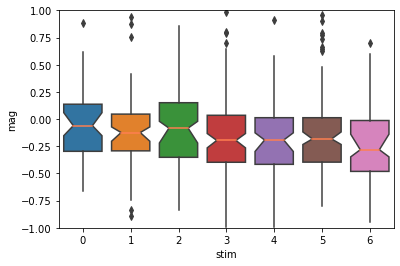

In [54]:
sns.boxplot(
    data=df_th_dropna, x="stim", y="mag",
    notch=True, showcaps=False,
    medianprops={"color": "coral"},
    bootstrap=10000,
)
# plt.xticks(np.arange(len(spatial_freq_arr)), spatial_freq_arr)
# plt.xticks(rotation=45)
# plt.xlabel('Preferred spatial frequency (cpd)')
# plt.ylabel('Adaptation index')
plt.ylim(-1, 1);

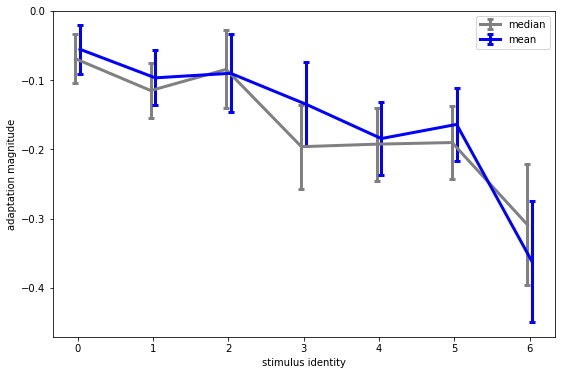

In [58]:
plt.figure(figsize=(9,6))
plt.errorbar(np.arange(nori)-0.03, mag_median, yerr=mag_sem, zorder=100, 
             color='gray', linewidth=3, capsize=3, capthick=3);
plt.errorbar(np.arange(nori)+0.03, mag_mean, yerr=mag_sem, zorder=100, 
             color='blue', linewidth=3, capsize=3, capthick=3);
plt.gca().set_ylim(top=0);
plt.legend(['median', 'mean'])
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity');

In [23]:
mag_sort_id = mag_median.argsort()
mag_median_sorted = mag_median[mag_sort_id[::-1]]
mag_sem_sorted_med = mag_sem[mag_sort_id[::-1]]

mag_sort_id = mag_mean.argsort()
mag_mean_sorted = mag_mean[mag_sort_id[::-1]]
mag_sem_sorted_mean = mag_sem[mag_sort_id[::-1]]

mag_median_sorted[0], mag_median_sorted[-1], mag_mean_sorted[0], mag_mean_sorted[-1]

(-0.06940276078821661,
 -0.30880371751985924,
 -0.05572221218796917,
 -0.36182924296996277)

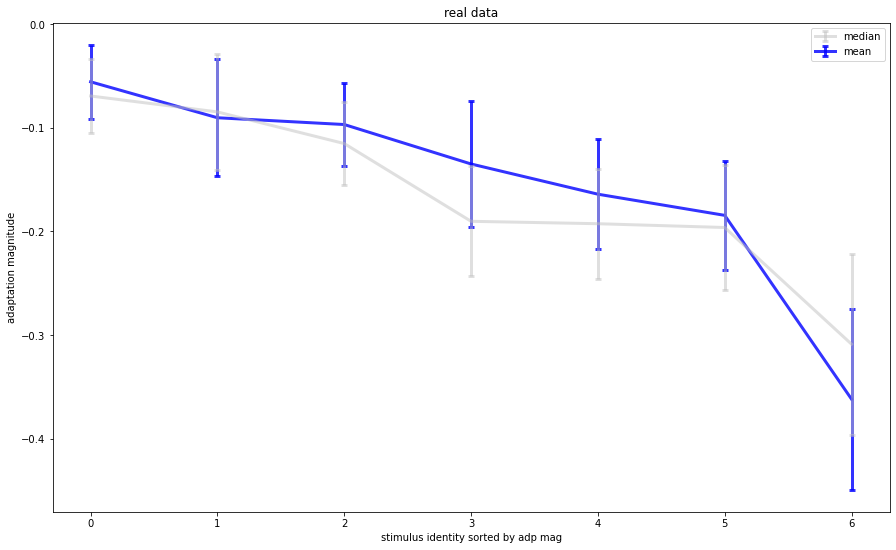

In [59]:
plt.figure(figsize=(15,9))
plt.errorbar(np.arange(nori), mag_median_sorted, yerr=mag_sem_sorted_med, zorder=2, 
             color='silver', linewidth=3, capsize=3, capthick=3, alpha=0.5);
plt.errorbar(np.arange(nori), mag_mean_sorted, yerr=mag_sem_sorted_mean, zorder=1, 
             color='blue', linewidth=3, capsize=3, capthick=3, alpha=0.8);
plt.legend(['median', 'mean'])
plt.ylabel('adaptation magnitude');
plt.xlabel('stimulus identity sorted by adp mag');
# plt.ylim(-2.3,0.1);
plt.title('real data');

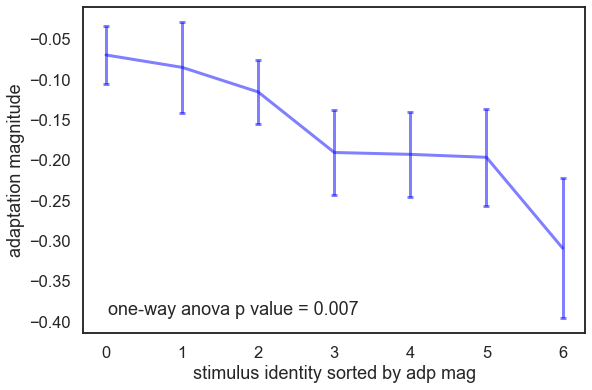

In [81]:
# poster fig result 2

sns.set_context("talk")
sns.set_style("white")

plt.figure(figsize=(9,6))
plt.errorbar(np.arange(nori), mag_median_sorted, yerr=mag_sem_sorted_med, zorder=2, 
             color='b', linewidth=3, capsize=3, capthick=3, alpha=0.5);
# plt.errorbar(np.arange(nori), mag_mean_sorted, yerr=mag_sem_sorted_mean, zorder=1, 
#              color='blue', linewidth=3, capsize=3, capthick=3, alpha=0.8);
# plt.legend(['median', 'mean'])

# add text lower left corner
plt.text(0.05, 0.1, 'one-way anova p value = 0.007', transform=plt.gca().transAxes, fontsize=18, verticalalignment='top')

plt.ylabel('adaptation magnitude', fontsize=18);
plt.xlabel('stimulus identity sorted by adp mag', fontsize=18);
# plt.ylim(-2.3,0.1);
# plt.title('real data');

# save as pdf
os.chdir(r'C:\Users\ll357\Documents\inter\results\poster 2022'.replace('\\','/'))
plt.savefig('adp across bunny7 imgs.pdf', bbox_inches='tight')

### compare w shuffle

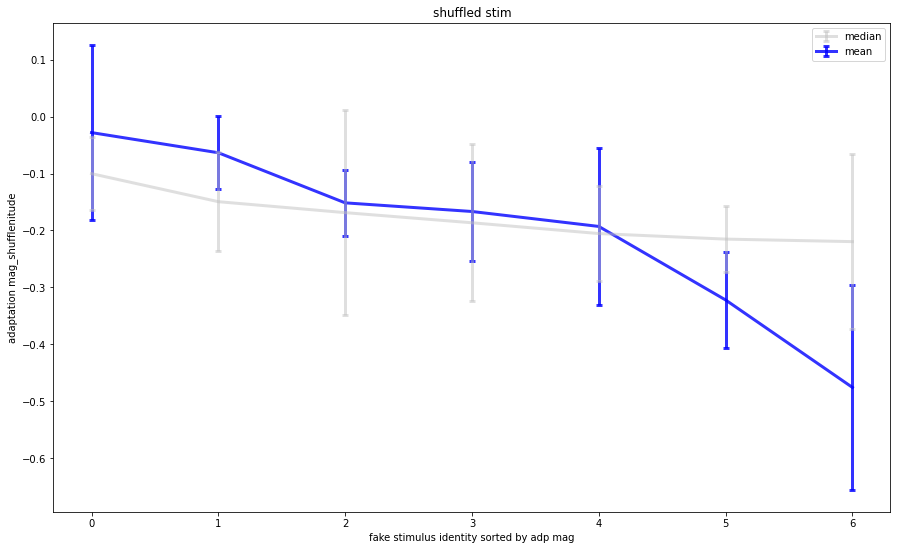

In [39]:
dfof_threshold = 0.0005
adp_threshold = 20 # 2

adp_shuffle = adp_mag.copy()
# print(adp_mag.shape) # ncell x nstim. should shuffle along rows (keep cell order, permute stim order)
adp_shuffle[np.abs(adp_shuffle) > adp_threshold] = np.nan

[np.random.shuffle(x) for x in adp_shuffle]; # shuffle every row

mag = adp_shuffle.flatten('F')

ad = dfof_ad.flatten('F')
mag[np.abs(ad) < dfof_threshold] = np.nan

stim = [np.arange(nori)] * adp_mag.shape[0]
stim_flat = np.sort([item for sublist in stim for item in sublist])

df_shuffle = pd.DataFrame({'stim':stim_flat, 'mag':mag, 'abs_mag':np.abs(mag)})
# df_shuffle.tail(5)

mag_shuffle_mean = df_shuffle[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
mag_shuffle_median = df_shuffle[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
mag_shuffle_std = df_shuffle[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
mag_shuffle_sem = df_shuffle[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
# df_shuffle[['mag','stim']].groupby(['stim'], sort=False).describe()

mag_shuffle_sort_id = mag_shuffle_median.argsort()
mag_shuffle_median_sorted = mag_shuffle_median[mag_shuffle_sort_id[::-1]]
mag_shuffle_sem_sorted_med = mag_shuffle_sem[mag_shuffle_sort_id[::-1]]

mag_shuffle_sort_id = mag_shuffle_mean.argsort()
mag_shuffle_mean_sorted = mag_shuffle_mean[mag_shuffle_sort_id[::-1]]
mag_shuffle_sem_sorted_mean = mag_shuffle_sem[mag_shuffle_sort_id[::-1]]
# mag_shuffle_median_sorted[0], mag_shuffle_median_sorted[-1], mag_shuffle_mean_sorted[0], mag_shuffle_mean_sorted[-1]

# plt.figure(figsize=(15,9))
# plt.errorbar(np.arange(nori), mag_shuffle_median_sorted, yerr=mag_shuffle_sem_sorted_med, zorder=2, 
#              color='silver', linewidth=3, capsize=3, capthick=3, alpha=0.5);
# plt.errorbar(np.arange(nori), mag_shuffle_mean_sorted, yerr=mag_shuffle_sem_sorted_mean, zorder=1, 
#              color='blue', linewidth=3, capsize=3, capthick=3, alpha=0.8);
# plt.legend(['median', 'mean'])
# plt.ylabel('adaptation mag_shufflenitude');
# plt.xlabel('fake stimulus identity sorted by adp mag');
# plt.title('shuffled stim');



(-0.4163867888313446, 0.1)

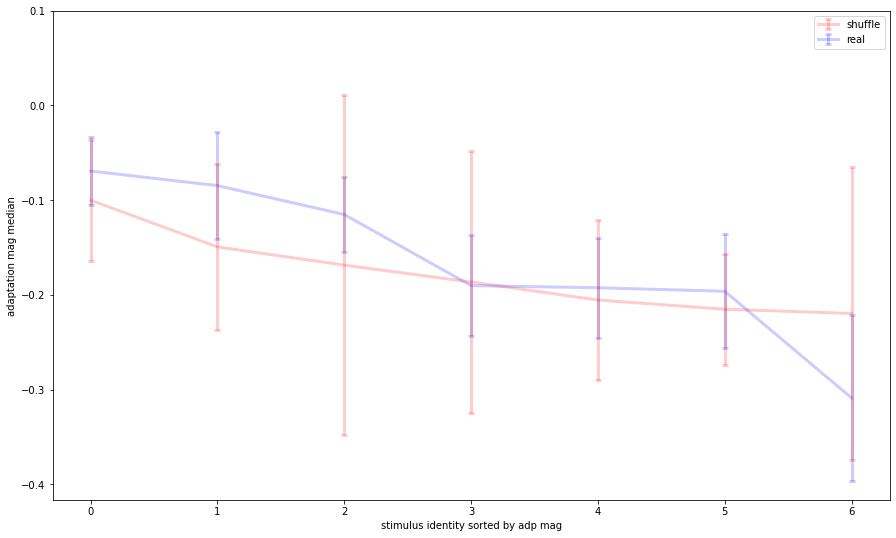

In [48]:
plt.figure(figsize=(15,9))
plt.errorbar(np.arange(nori), mag_shuffle_median_sorted, yerr=mag_shuffle_sem_sorted_med, zorder=2, 
             color='red', linewidth=3, capsize=3, capthick=3, alpha=0.2);
plt.errorbar(np.arange(nori), mag_median_sorted, yerr=mag_sem_sorted_med, zorder=1, 
             color='blue', linewidth=3, capsize=3, capthick=3, alpha=0.2);
plt.legend(['shuffle', 'real'])
plt.ylabel('adaptation mag median');
plt.xlabel('stimulus identity sorted by adp mag');
plt.gca().set_ylim(top=0.1)

(-0.6947922430703625, 0.2)

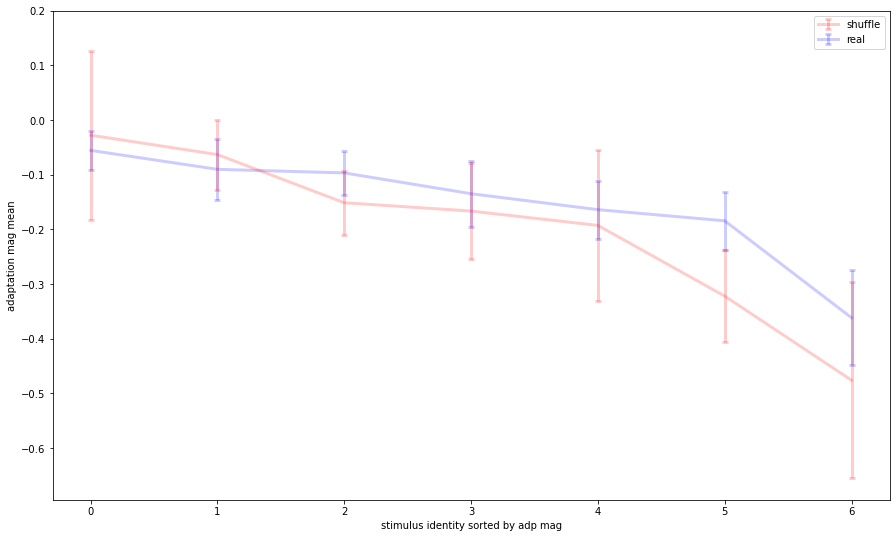

In [46]:
plt.figure(figsize=(15,9))
plt.errorbar(np.arange(nori), mag_shuffle_mean_sorted, yerr=mag_shuffle_sem_sorted_mean, zorder=2, 
             color='red', linewidth=3, capsize=3, capthick=3, alpha=0.2);
plt.errorbar(np.arange(nori), mag_mean_sorted, yerr=mag_sem_sorted_mean, zorder=1, 
             color='blue', linewidth=3, capsize=3, capthick=3, alpha=0.2);
plt.legend(['shuffle', 'real'])
plt.ylabel('adaptation mag mean');
plt.xlabel('stimulus identity sorted by adp mag');
plt.gca().set_ylim(top=0.2)

### dfof_ad & dfof_tg across stims

In [288]:
df_th.loc[df_th[np.abs(df.ad) < dfof_threshold].index.to_numpy(),['ad','tg','mag']] = np.nan # threshold by dfof_ad
df_th.tail()

,stim,mag,ad,tg
842,6,-0.303705,0.017647,0.012288
843,6,-0.946363,0.010285,0.000552
844,6,NaN,NaN,NaN
845,6,0.509572,0.008689,0.013116
846,6,0.004448,0.014066,0.014128


In [307]:
stim_flat_cp = np.concatenate([df_th.stim, df_th.stim])
dfof_flat = np.concatenate([df_th.ad, df_th.tg])
adtg_flat = [['ad','tg']] * df_th.shape[0]
adtg_flat = np.sort([item for sublist in adtg_flat for item in sublist])
df_cp = pd.DataFrame({'stim':stim_flat_cp, 'dfof': dfof_flat, 'ad_or_tg': adtg_flat})
df_cp

,stim,dfof,ad_or_tg
0,0,0.004911,ad
1,0,0.096553,ad
2,0,0.043873,ad
3,0,0.023006,ad
4,0,0.048574,ad
...,...,...,...
1689,6,0.012288,tg
1690,6,0.000552,tg
1691,6,NaN,tg
1692,6,0.013116,tg


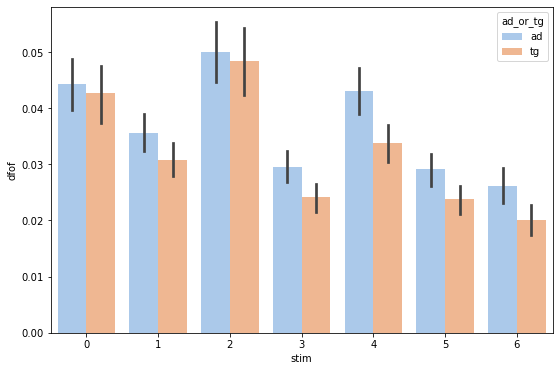

In [314]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x="stim", y="dfof", hue="ad_or_tg", data=df_cp, ci=68, palette="pastel") # mean +- sem

## Trace

In [235]:
trace_mean = np.mean(trace, axis=0)
trace_std = np.std(trace, axis=0)
trace_sem = trace_std / np.sqrt(trace.shape[0])

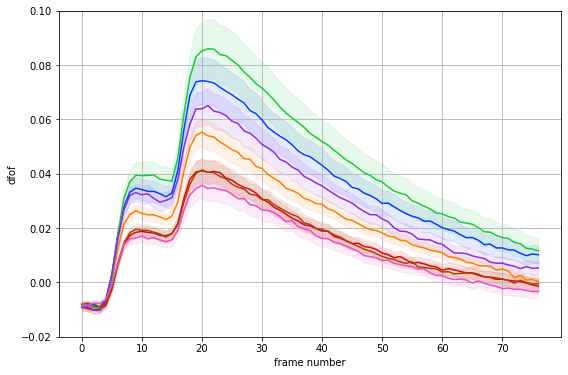

In [317]:
# fig, ax = plt.subplots(figsize=(20,15))
fig, ax = plt.subplots(figsize=(9,6))

for iori in np.arange(nori):
    ax.plot(np.arange(trace.shape[2]), trace_mean[iori,:].flatten(), color=sns.color_palette("bright")[iori])
    ax.fill_between(np.arange(trace.shape[2]), 
                    trace_mean[iori,:].flatten() + trace_sem[iori,:].flatten(), 
                    trace_mean[iori,:].flatten() - trace_sem[iori,:].flatten(),
                    color=sns.color_palette("bright")[iori], alpha=0.1)
plt.grid('minor')
plt.ylim(-0.02,0.10)
plt.xlabel('frame number')
plt.ylabel('dfof')
plt.show()

## Dim Reduct
discard neurons with abs_adp > 2  
then use full data, unadapted trials, or adapted trials to do PCA / TSNE

In [39]:
df.describe()

,stim,ad,tg,mag,abs_mag
count,847.000000,847.000000,847.000000,764.000000,764.000000
mean,3.000000,0.035017,0.030416,-0.147451,1.045952
std,2.001182,0.041916,0.041385,9.134612,9.075652
min,0.000000,-0.011902,-0.023221,-139.651267,0.004448
25%,1.000000,0.009704,0.007352,-0.415143,0.146119
50%,3.000000,0.022601,0.018682,-0.173957,0.302292
75%,5.000000,0.042939,0.038132,0.091079,0.568321
max,6.000000,0.374842,0.367123,205.983176,205.983176


In [42]:
df = df[df.abs_mag <= 2]
df.describe()

,stim,ad,tg,mag,abs_mag
count,726.000000,726.000000,726.000000,726.000000,726.000000
mean,3.093664,0.040117,0.034633,-0.138751,0.375298
std,1.952410,0.043105,0.043079,0.483497,0.334671
min,0.000000,-0.011902,-0.009825,-1.902921,0.004448
25%,1.000000,0.013377,0.010097,-0.395813,0.138016
50%,3.000000,0.027999,0.022886,-0.160898,0.288324
75%,5.000000,0.048379,0.041832,0.084853,0.505632
max,6.000000,0.374842,0.367123,1.723560,1.902921


In [43]:
(764-726)/764 # percentage of discarded neurons

0.049738219895287955

Median abs adaptation magnitude:  0.2883239705168946


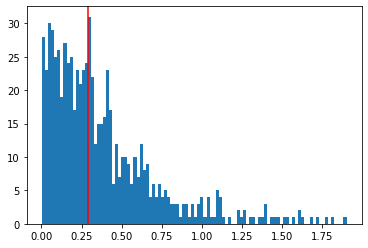

In [44]:
plt.hist(df.abs_mag, bins = 100)
print("Median abs adaptation magnitude: ", df.abs_mag.median())

adapted_cells = df[df.abs_mag > df.abs_mag.median()]
less_adapted_cells = df[df.abs_mag <= df.abs_mag.median()]

plt.axvline(df.abs_mag.median(), color = 'red')

In [45]:
df

,stim,ad,tg,mag,abs_mag
1,0,0.096553,0.070448,-0.270371,0.270371
2,0,0.043873,0.061639,0.404955,0.404955
3,0,0.023006,0.024814,0.078625,0.078625
4,0,0.048574,0.052035,0.071251,0.071251
5,0,0.034395,0.036364,0.057247,0.057247
...,...,...,...,...,...
841,6,0.018192,-0.000038,-1.002062,1.002062
842,6,0.017647,0.012288,-0.303705,0.303705
843,6,0.010285,0.000552,-0.946363,0.946363
845,6,0.008689,0.013116,0.509572,0.509572


### TSNE full data
construct feature matrix

In [89]:
temp = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dim_red' + '.mat'))
temp.keys()

dict_keys(['__header__', '__version__', '__globals__', 'adp_vis', 'dim_red_ad', 'dim_red_tg', 'feature_ad', 'feature_tg'])

In [64]:
df_adp = pd.DataFrame(temp['adp_vis'])
df_adp.columns = ['vis_ad', 'adp_abs']
df_adp.tail()

,vis_ad,adp_abs
116,1.0,4.565699
117,1.0,2.562222
118,1.0,8.322635
119,1.0,4.454923
120,1.0,6.494584


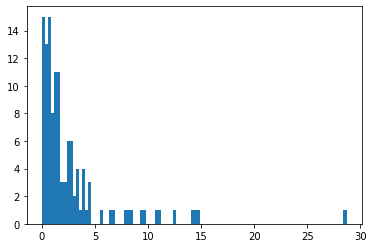

In [55]:
plt.hist(df_adp.adp_abs, 100);

In [66]:
df_adp.loc[df_adp.adp_abs > 5, 'adp_abs'] = np.nan
df_adp.loc[df_adp.vis_ad == 0, 'adp_abs'] = np.nan
df_adp

,vis_ad,adp_abs
0,1.0,0.088567
1,1.0,0.917359
2,1.0,1.179459
3,1.0,0.764187
4,1.0,NaN
...,...,...
116,1.0,4.565699
117,1.0,2.562222
118,1.0,NaN
119,1.0,4.454923


In [73]:
cell_id = np.arange(len(df_adp))
df_adp['cell_id'] = cell_id
df_adp.drop(columns='vis_ad', inplace=True)
df_adp

,adp_abs,cell_id
0,0.088567,0
1,0.917359,1
2,1.179459,2
3,0.764187,3
4,NaN,4
...,...,...
116,4.565699,116
117,2.562222,117
118,NaN,118
119,4.454923,119


In [76]:
df = df_adp[~np.isnan(df_adp.adp_abs)].copy()
df

,adp_abs,cell_id
0,0.088567,0
1,0.917359,1
2,1.179459,2
3,0.764187,3
5,0.135568,5
...,...,...
114,0.019841,114
115,3.940548,115
116,4.565699,116
117,2.562222,117


Median adaptation magnitude:  1.2532096517537439


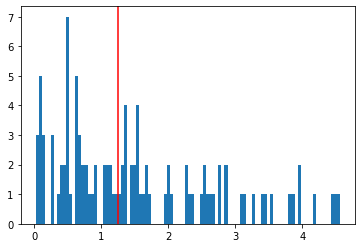

In [77]:
plt.hist(df.adp_abs, bins = 100)
adp_median = np.median(df.adp_abs)
print("Median adaptation magnitude: ", adp_median)
plt.axvline(adp_median, color = 'red')

In [95]:
adapt_cells = df[df.adp_abs > adp_median].cell_id.values
robust_cells = df[df.adp_abs <= adp_median].cell_id.values
robust_cells

array([  0,   1,   2,   3,   5,   7,   8,   9,  13,  15,  16,  20,  32,
        33,  34,  36,  39,  40,  41,  47,  48,  51,  52,  57,  58,  59,
        61,  62,  63,  64,  65,  68,  69,  70,  74,  75,  79,  80,  81,
        83,  84,  85,  86,  87,  88,  89,  91,  93,  94,  96, 105, 114])

In [109]:
feature_ad = pd.DataFrame(temp['feature_ad']) # ntrial x ncell of adapter response
feature_tg = pd.DataFrame(temp['feature_tg']) # ntrial x ncell of target response
feature_full = pd.concat([feature_ad, feature_tg], axis=0) # full response

dim_red_ad = pd.DataFrame(temp['dim_red_ad']) # ntrial x ncell of adapter response
dim_red_tg = pd.DataFrame(temp['dim_red_tg']) # ntrial x ncell of target response
dim_red_full = pd.concat([dim_red_ad, dim_red_tg], axis=0) # full response

In [110]:
adapt_cells_features = feature_full.loc[:, adapt_cells]
robust_cells_features = feature_full.loc[:, robust_cells]

adapt_cells_df = dim_red_full.loc[:, adapt_cells]
robust_cells_df = dim_red_full.loc[:, robust_cells]

In [117]:
dim_red_full.rename(columns={0:'img_id'}, inplace=True)
dim_red_full.rename(columns={1:'rep_num'}, inplace=True)
dim_red_full[['img_id', 'rep_num']]

,img_id,rep_num
0,6.0,0.0
1,2.0,0.0
2,2.0,0.0
3,1.0,0.0
4,2.0,0.0
...,...,...
1268,0.0,1.0
1269,5.0,1.0
1270,1.0,1.0
1271,3.0,1.0


In [118]:
adapt_tsne = TSNE(n_components=2, init='random',
                  random_state=0, perplexity=30, n_iter = 3000)


adapt_tsne_fit = adapt_tsne.fit_transform(adapt_cells_features)

adapt_tsne_df = pd.DataFrame(data = adapt_tsne_fit, columns = ['comp1', 'comp2']) #put the labels (image index and repeat number) back for plotting

adapt_tsne_df = pd.concat([adapt_tsne_df, dim_red_full[['img_id', 'rep_num']].reset_index()], axis = 1)

2.0862438678741455


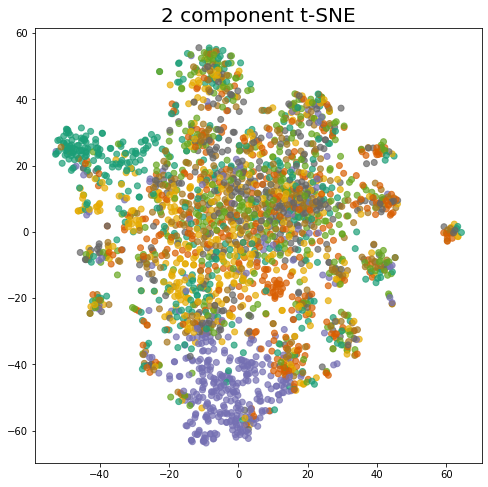

In [120]:
plt.figure(figsize = (8,8))
plt.title('2 component t-SNE', fontsize = 20)
plt.scatter(adapt_tsne_df.comp1, adapt_tsne_df.comp2, c = adapt_tsne_df.img_id, cmap = 'Dark2', alpha = 0.7)

print(adapt_tsne.kl_divergence_)

2.1693551540374756


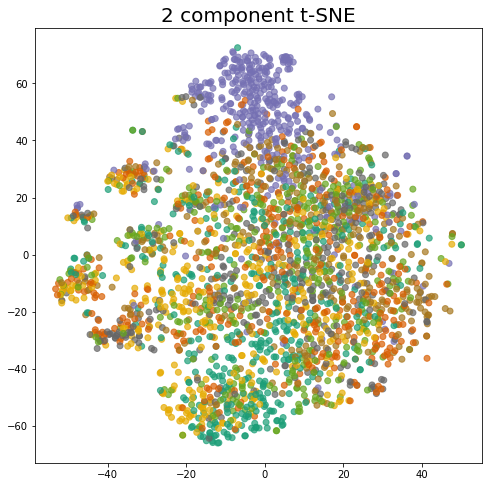

In [121]:
robust_tsne = TSNE(n_components=2, init='random',
                   random_state=0, perplexity=30, n_iter = 3000)
robust_tsne_fit = robust_tsne.fit_transform(robust_cells_features)

robust_tsne_df = pd.DataFrame(data =robust_tsne_fit, columns = ['comp1', 'comp2'])
robust_tsne_df  = pd.concat([robust_tsne_df, dim_red_full[['img_id', 'rep_num']].reset_index()], axis = 1)

plt.figure(figsize = (8,8))
plt.title('2 component t-SNE', fontsize = 20)
plt.scatter(robust_tsne_df.comp1, robust_tsne_df.comp2, c = robust_tsne_df.img_id, cmap = 'Dark2', alpha = 0.7)

print(robust_tsne.kl_divergence_)

### PCA, full data

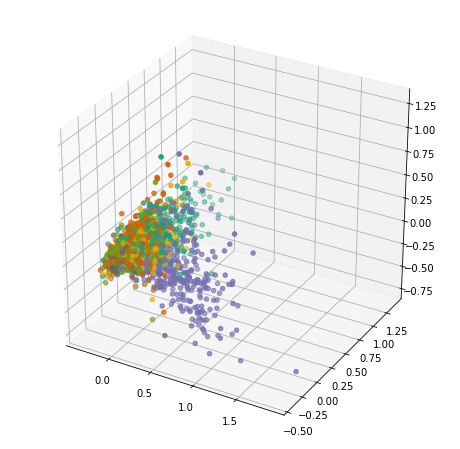

In [123]:
above_pca = PCA(n_components = 3)
above_principal_pcs = above_pca.fit_transform(adapt_cells_features)

above_principal_df = pd.DataFrame(data = above_principal_pcs, columns = ['pc1', 'pc2', 'pc3'])
above_principal_df = pd.concat([above_principal_df, dim_red_full[['img_id', 'rep_num']].reset_index()], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(above_principal_df.pc1, above_principal_df.pc2, above_principal_df.pc3, c = above_principal_df.img_id, cmap = 'Dark2' )
#ax.view_init(60, 30) 

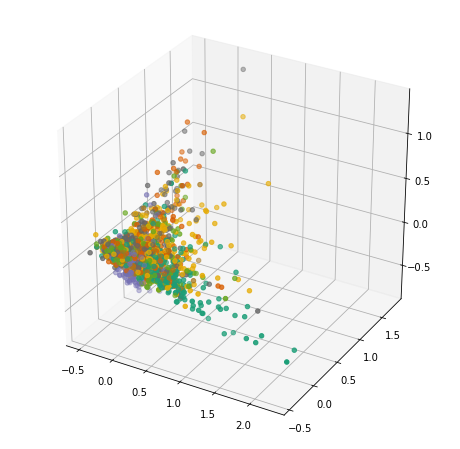

In [122]:
below_pca = PCA(n_components = 3)
below_principal_pcs = below_pca.fit_transform(robust_cells_features)

below_principal_df = pd.DataFrame(data = below_principal_pcs, columns = ['pc1', 'pc2', 'pc3'])
below_principal_df = pd.concat([below_principal_df, dim_red_full[['img_id', 'rep_num']].reset_index()], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(below_principal_df.pc1, below_principal_df.pc2, below_principal_df.pc3, c = below_principal_df.img_id, cmap = 'Dark2' )
#ax.view_init(60, 30) 

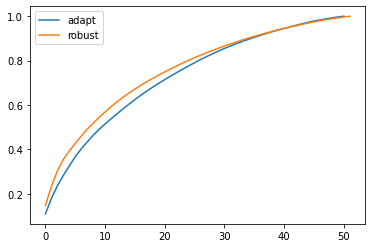

In [127]:
above_pca = PCA()
below_pca = PCA()

above_pcs = above_pca.fit_transform(adapt_cells_features)
below_pcs = below_pca.fit_transform(robust_cells_features)

plt.plot(np.cumsum(above_pca.explained_variance_ratio_))
plt.plot(np.cumsum(below_pca.explained_variance_ratio_))
plt.legend(['adapt', 'robust']);

## Misc
### Adaptation increases variability for natural stim too
for target after adaptation, fano factor is higher than adapter  
cell selection: vis_ad only, with thresholding of dfof_ad

In [270]:
adp_fano_tg = dfof_tg_std / dfof_tg
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad)

In [274]:
adp_fano_tg = dfof_tg_std / dfof_tg
adp_fano_ad = dfof_ad_std / dfof_ad
adp_fano = (adp_fano_tg - adp_fano_ad) / (adp_fano_tg + adp_fano_ad) # range [-1,1], meaning fano factor de/increase after adp

df_fano = df_th.copy()
df_fano['fano'] = adp_fano.flatten('F')
df_fano.tail()

,stim,mag,ad,fano
842,6,-0.303705,0.017647,0.227742
843,6,-0.946363,0.010285,0.885427
844,6,NaN,-0.000823,-1.808887
845,6,0.509572,0.008689,-0.184105
846,6,0.004448,0.014066,0.071005


In [273]:
df_fano[['fano','stim']].groupby(['stim'], sort=False).describe()

fano                                                               \
      count      mean       std        min       25%       50%       75%   
stim                                                                       
0     121.0  0.052920  0.576917  -4.594001 -0.047361  0.093442  0.209409   
1     121.0  0.135430  5.407791 -26.093405  0.014326  0.089195  0.193997   
2     121.0 -0.158760  2.430507 -26.077591 -0.056197  0.065722  0.194823   
3     121.0 -0.084555  3.564811 -37.400224 -0.003067  0.140460  0.281348   
4     121.0  0.149605  0.823570  -4.510934  0.010311  0.113901  0.250512   
5     121.0 -0.158757  1.653200 -15.050779 -0.021480  0.088770  0.240371   
6     121.0  0.719988  6.736332  -7.174958 -0.007540  0.150818  0.378640   

                 
            max  
stim             
0      1.720485  
1     49.631555  
2      2.801406  
3     10.253987  
4      4.552109  
5      1.686991  
6     72.969290

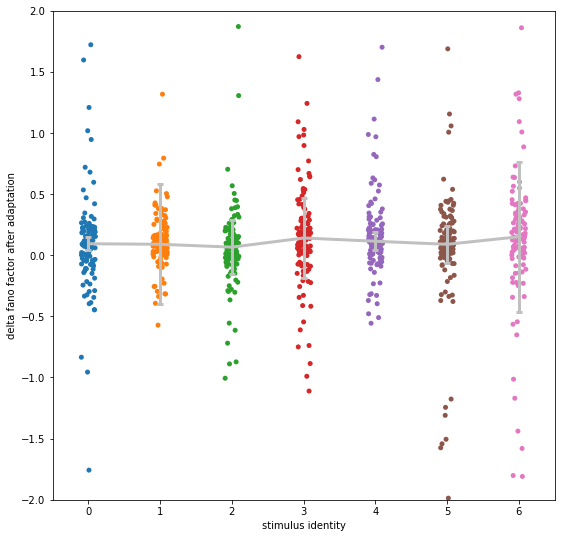

In [278]:
fano_mean = df_fano[['fano','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
fano_median = df_fano[['fano','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
fano_std = df_fano[['fano','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
fano_sem = df_fano[['fano','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()

plt.figure(figsize=(9,9))
plt.errorbar(np.arange(nori), fano_median, yerr=fano_sem, zorder=100, 
             color='silver', linewidth=3, capsize=3, capthick=3);
sns.stripplot(x="stim", y="fano", data=df_fano);
plt.ylabel('delta fano factor after adaptation');
plt.xlabel('stimulus identity');
plt.ylim(-2,2);

### stim presentation order

In [12]:
dir_behav = 'Z:/All_Staff/home/lan/Data/2P_images/i1338/210616'
behav = scipy.io.loadmat(os.path.join(dir_behav, 'input_behav.mat'))

dict_keys(['__header__', '__version__', '__globals__', 'stim1', 'stim2'])

In [24]:
flat_list = [item for sublist in behav['stim1'] for item in sublist]
flat_list = [item for sublist in flat_list for item in sublist]
flat_list = [item for sublist in flat_list for item in sublist]
stim1 = np.array(flat_list)

# flat_list = [item for sublist in behav['stim2'] for item in sublist]
# flat_list = [item for sublist in flat_list for item in sublist]
# flat_list = [item for sublist in flat_list for item in sublist]
# stim2 = np.array(flat_list)
# stim2 == stim1

In [31]:
values, counts = np.unique(stim1, return_counts=True)
counts

array([190, 182, 190, 183, 181, 173, 175], dtype=int64)